In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import log_loss
from catboost import CatBoostClassifier
from sklearn.cluster import KMeans

C:\Anaconda\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.ensemble.forest module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [4]:
train['date_time'] = pd.to_datetime(train['date'], format='%d/%m/%y')
train['year'] = train['date_time'].dt.year
train['month'] = train['date_time'].dt.month
train['weekday'] = train['date_time'].dt.weekday
train['day'] = train.date_time.dt.day

In [5]:
test['date_time'] = pd.to_datetime(test['date'], format='%d/%m/%y')
test['year'] = test['date_time'].dt.year
test['month'] = test['date_time'].dt.month
test['weekday'] = test['date_time'].dt.weekday
test['day'] = test.date_time.dt.day

In [6]:
train['see']= train.year - train.season
test['see']= test.year - test.season

In [7]:
df = pd.concat([train, test], axis=0)

In [9]:
df['season_by_league_cnt']= df.groupby(['league'])['season'].transform('count')

In [11]:
km= KMeans(n_clusters=3, max_iter=300, init='k-means++',tol= 0.0001, n_init=10, random_state=0)
df['clusters'] = km.fit_predict(df[['season', 'league_id','SPI1', 'SPI2','proj_score1', 'proj_score1']])

In [12]:
df['proj_score1_by_team1_mean']= df.groupby('Team 1')['proj_score1'].transform('mean')
df['proj_score1_by_team1_mean']= df.groupby('Team2')['proj_score2'].transform('median')
df['proj_score1_by_team1_mean']= df.groupby('Team 1')['proj_score1'].transform('mean')
df['proj_score1_by_team1_mean']= df.groupby('Team2')['proj_score2'].transform('median')

In [13]:
df['league_cnt']= df.groupby(['league'])['league_id'].transform('count')
df['match']= df['Team 1'].astype(str) + ' VS ' + df['Team2'].astype(str)
df['sea_id']= df.season - df.league_id

In [15]:
df['spi']= df.SPI1 + df.SPI2
df['real_spi'] = 100- df['spi']

In [16]:
seasons = pd.get_dummies(df.season, drop_first=True, prefix= 'season_')
df = df.drop('season', axis= 1)
df = pd.concat([df, seasons], axis=1)

In [17]:
le = LabelEncoder()
le.fit(df.league_id)
df.league_id= le.transform(df.league_id)

In [18]:
le = LabelEncoder()
le.fit(df.league)
df.league= le.transform(df.league)

In [19]:
le = LabelEncoder()
le.fit(df['Team 1'])
df['Team 1']= le.transform(df['Team 1'])

In [20]:
le = LabelEncoder()
le.fit(train.Team2)
df.Team2= le.transform(df.Team2)

In [21]:
le = LabelEncoder()
le.fit(df.Team2)
df.Team2= le.transform(df.Team2)

In [22]:
le = LabelEncoder()
le.fit(df.sea_id)
df.sea_id= le.transform(df.sea_id)

In [23]:
le = LabelEncoder()
le.fit(df.match)
df.match= le.transform(df.match)

In [24]:
df['proj_score_add']=df.proj_score1 + df.proj_score2
df['proj_score_sub']=df.proj_score1 - df.proj_score2
df['proj_score_mul']=df.proj_score1 * df.proj_score2
df['proj_score_div']=df.proj_score1 / df.proj_score2

In [25]:
df['cmon0']= df.proj_score_sub + df.proj_score_div
df['cmon1']= df.proj_score_sub - df.proj_score_div
df['cmon2']= df.proj_score_sub * df.proj_score_div
df['cmon3']= df.proj_score_sub / df.proj_score_div

In [26]:
df['cm2_3_sum'] = df.cmon2 + df.cmon3
df['cm2_3_sub'] = df.cmon2 - df.cmon3
df['cm2_3_mul'] = df.cmon2 * df.cmon3
df['cm2_3_div'] = df.cmon2 / df.cmon3

In [27]:
train = df[:7443]
test = df[7443:]

In [ ]:
plt.figure(figsize=(26,10))
sns.heatmap(train.corr('spearman'), annot= True)

In [28]:
[var for var in train.columns if train[var].dtypes != 'O']

['league_id',
 'league',
 'Team 1',
 'Team2',
 'SPI1',
 'SPI2',
 'proj_score1',
 'proj_score2',
 'importance1',
 'importance2',
 'score1',
 'score2',
 'xg1',
 'xg2',
 'nsxg1',
 'nsxg2',
 'adj_score1',
 'adj_score2',
 'Outcome',
 'date_time',
 'year',
 'month',
 'weekday',
 'day',
 'see',
 'season_by_league_cnt',
 'clusters',
 'proj_score1_by_team1_mean',
 'league_cnt',
 'match',
 'sea_id',
 'spi',
 'real_spi',
 'season__2020',
 'season__2021',
 'proj_score_add',
 'proj_score_sub',
 'proj_score_mul',
 'proj_score_div',
 'cmon0',
 'cmon1',
 'cmon2',
 'cmon3',
 'cm2_3_sum',
 'cm2_3_sub',
 'cm2_3_mul',
 'cm2_3_div']

In [65]:
cont_cols = ['league_id',
 'league',
 'Team 1',
 'Team2',
 'SPI1',
 'SPI2',
 'proj_score1',
 'proj_score2',
 'importance1',
 'importance2',
 'score1',
 'score2',
 'xg1',
 'xg2',
 'nsxg1',
 'nsxg2',
 'adj_score1',
 'adj_score2',
 'month',
 'weekday',
 'day',
 'see',
 'season_by_league_cnt',
 'clusters',
 'proj_score1_by_team1_mean',
 'league_cnt',
 'match',
 'sea_id',
 'spi',
 'real_spi',
 'season__2020',
 'season__2021',
 'proj_score_add',
 'proj_score_sub',
 'proj_score_mul',
 'proj_score_div',
 'cmon0',
 'cmon1',
 'cmon2',
 'cmon3',
 'cm2_3_sum',
 'cm2_3_sub',
 'cm2_3_mul',
 'cm2_3_div']

In [78]:
X_train = train[cont_cols]
y_train = train.Outcome
X_test = test[cont_cols]

In [71]:
cat_param= {'learning_rate': 0.00840101589650981,
 'colsample_bylevel': 0.09617710779199803,
 'depth': 6,
 'l2_leaf_reg': 3,
 'boosting_type': 'Ordered',
 'bootstrap_type': 'Bernoulli',
 'subsample': 0.9152369873734315}

In [79]:
n_folds = 10
subbed = []
kf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=10)


for fold, (train_idx, test_idx) in enumerate(kf.split(X_train, y_train)):
    print('=============== Fold No:',fold+1,'===============')
    X_tr, X_tst = X_train.iloc[train_idx], X_train.iloc[test_idx]
    y_tr, y_tst = y_train.iloc[train_idx], y_train.iloc[test_idx]
    
    model = CatBoostClassifier(n_estimators=2500, random_state=10, eval_metric='Logloss', **cat_param)
    model.fit(X_tr, y_tr,eval_set=[(X_tst, y_tst)], early_stopping_rounds=50, verbose=500)
    print(log_loss(y_tst, model.predict_proba(X_tst)))
    subbed.append(log_loss(y_tst, model.predict_proba(X_tst)))
    pred = model.predict_proba(X_test)
print(np.mean(subbed))

=============== Fold No: 1 ===============
0:	learn: 0.6660088	test: 0.6662258	best: 0.6662258 (0)	total: 24.8ms	remaining: 1m 1s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.02251113517
bestIteration = 384

Shrink model to first 385 iterations.
0.022511135172472163
=============== Fold No: 2 ===============
0:	learn: 0.6667296	test: 0.6663140	best: 0.6663140 (0)	total: 19.5ms	remaining: 48.7s
500:	learn: 0.0080270	test: 0.0110935	best: 0.0110851 (498)	total: 11.3s	remaining: 45.3s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.01088367359
bestIteration = 571

Shrink model to first 572 iterations.
0.010883673588050176
=============== Fold No: 3 ===============
0:	learn: 0.6666326	test: 0.6667917	best: 0.6667917 (0)	total: 22.7ms	remaining: 56.8s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.01345719024
bestIteration = 355

Shrink model to first 356 iterations.
0.01345719023549195
=============== Fold No: 4 ==============

In [80]:
# function for creating a feature importance dataframe
def imp_df(column_names, importances):
    df = pd.DataFrame({'feature': column_names,
                       'feature_importance': importances}) \
           .sort_values('feature_importance', ascending = False) \
           .reset_index(drop = True)
    return df

# plotting a feature importance dataframe (horizontal barchart)
def var_imp_plot(imp_df):
    plt.figure(figsize=(15,10))
    imp_df.columns = ['feature', 'feature_importance']
    sns.barplot(x = 'feature_importance', y = 'feature', data = imp_df, orient = 'h', color = 'royalblue')

In [75]:
def r2(rf, X_train, y_train):
    return log_loss(y_train, model.predict_proba(X_train))

perm_imp_rfpimp = permutation_importances(model, X_train, y_train, r2)
perm_imp_rfpimp.reset_index(drop = False, inplace = True)

0:	learn: 0.6706918	total: 14.6ms	remaining: 36.4s
1:	learn: 0.6471246	total: 27.9ms	remaining: 34.8s
2:	learn: 0.6236301	total: 50.5ms	remaining: 42s
3:	learn: 0.6012286	total: 65ms	remaining: 40.5s
4:	learn: 0.5783534	total: 80ms	remaining: 39.9s
5:	learn: 0.5585125	total: 93.3ms	remaining: 38.8s
6:	learn: 0.5378209	total: 107ms	remaining: 38.1s
7:	learn: 0.5146269	total: 125ms	remaining: 39s
8:	learn: 0.4943340	total: 136ms	remaining: 37.7s
9:	learn: 0.4745550	total: 150ms	remaining: 37.4s
10:	learn: 0.4576828	total: 167ms	remaining: 37.8s
11:	learn: 0.4402051	total: 179ms	remaining: 37s
12:	learn: 0.4239494	total: 193ms	remaining: 36.9s
13:	learn: 0.4068315	total: 212ms	remaining: 37.7s
14:	learn: 0.3919149	total: 228ms	remaining: 37.8s
15:	learn: 0.3790241	total: 242ms	remaining: 37.6s
16:	learn: 0.3666343	total: 256ms	remaining: 37.3s
17:	learn: 0.3537176	total: 274ms	remaining: 37.8s
18:	learn: 0.3426285	total: 289ms	remaining: 37.8s
19:	learn: 0.3287761	total: 304ms	remaining: 

161:	learn: 0.0186377	total: 2.4s	remaining: 34.6s
162:	learn: 0.0185848	total: 2.41s	remaining: 34.6s
163:	learn: 0.0183542	total: 2.43s	remaining: 34.6s
164:	learn: 0.0182166	total: 2.45s	remaining: 34.6s
165:	learn: 0.0180379	total: 2.46s	remaining: 34.6s
166:	learn: 0.0179044	total: 2.48s	remaining: 34.6s
167:	learn: 0.0177648	total: 2.49s	remaining: 34.6s
168:	learn: 0.0175991	total: 2.5s	remaining: 34.6s
169:	learn: 0.0174755	total: 2.52s	remaining: 34.5s
170:	learn: 0.0173373	total: 2.54s	remaining: 34.5s
171:	learn: 0.0172062	total: 2.55s	remaining: 34.5s
172:	learn: 0.0170919	total: 2.56s	remaining: 34.5s
173:	learn: 0.0169509	total: 2.58s	remaining: 34.5s
174:	learn: 0.0167324	total: 2.6s	remaining: 34.5s
175:	learn: 0.0165524	total: 2.61s	remaining: 34.5s
176:	learn: 0.0164199	total: 2.63s	remaining: 34.5s
177:	learn: 0.0162986	total: 2.64s	remaining: 34.5s
178:	learn: 0.0161568	total: 2.66s	remaining: 34.5s
179:	learn: 0.0160496	total: 2.67s	remaining: 34.5s
180:	learn: 0.0

321:	learn: 0.0081701	total: 4.77s	remaining: 32.2s
322:	learn: 0.0081521	total: 4.78s	remaining: 32.2s
323:	learn: 0.0081016	total: 4.79s	remaining: 32.2s
324:	learn: 0.0080884	total: 4.81s	remaining: 32.2s
325:	learn: 0.0080688	total: 4.82s	remaining: 32.1s
326:	learn: 0.0080585	total: 4.83s	remaining: 32.1s
327:	learn: 0.0080447	total: 4.84s	remaining: 32s
328:	learn: 0.0080251	total: 4.86s	remaining: 32.1s
329:	learn: 0.0080068	total: 4.87s	remaining: 32s
330:	learn: 0.0079948	total: 4.89s	remaining: 32s
331:	learn: 0.0079665	total: 4.9s	remaining: 32s
332:	learn: 0.0079285	total: 4.91s	remaining: 32s
333:	learn: 0.0079121	total: 4.93s	remaining: 31.9s
334:	learn: 0.0079008	total: 4.95s	remaining: 32s
335:	learn: 0.0078842	total: 4.96s	remaining: 32s
336:	learn: 0.0078772	total: 4.98s	remaining: 31.9s
337:	learn: 0.0078563	total: 4.99s	remaining: 31.9s
338:	learn: 0.0078437	total: 5s	remaining: 31.9s
339:	learn: 0.0078042	total: 5.01s	remaining: 31.8s
340:	learn: 0.0077725	total: 5

483:	learn: 0.0052794	total: 7.13s	remaining: 29.7s
484:	learn: 0.0052768	total: 7.14s	remaining: 29.7s
485:	learn: 0.0052645	total: 7.16s	remaining: 29.7s
486:	learn: 0.0052604	total: 7.17s	remaining: 29.6s
487:	learn: 0.0052531	total: 7.19s	remaining: 29.6s
488:	learn: 0.0052455	total: 7.2s	remaining: 29.6s
489:	learn: 0.0052402	total: 7.22s	remaining: 29.6s
490:	learn: 0.0052349	total: 7.22s	remaining: 29.6s
491:	learn: 0.0052233	total: 7.24s	remaining: 29.6s
492:	learn: 0.0052034	total: 7.26s	remaining: 29.5s
493:	learn: 0.0051913	total: 7.27s	remaining: 29.5s
494:	learn: 0.0051676	total: 7.29s	remaining: 29.5s
495:	learn: 0.0051618	total: 7.3s	remaining: 29.5s
496:	learn: 0.0051578	total: 7.32s	remaining: 29.5s
497:	learn: 0.0051523	total: 7.33s	remaining: 29.5s
498:	learn: 0.0051437	total: 7.34s	remaining: 29.4s
499:	learn: 0.0051356	total: 7.36s	remaining: 29.4s
500:	learn: 0.0051276	total: 7.37s	remaining: 29.4s
501:	learn: 0.0051095	total: 7.39s	remaining: 29.4s
502:	learn: 0.

649:	learn: 0.0038328	total: 9.52s	remaining: 27.1s
650:	learn: 0.0038286	total: 9.54s	remaining: 27.1s
651:	learn: 0.0038243	total: 9.55s	remaining: 27.1s
652:	learn: 0.0038243	total: 9.57s	remaining: 27.1s
653:	learn: 0.0038202	total: 9.58s	remaining: 27s
654:	learn: 0.0038099	total: 9.59s	remaining: 27s
655:	learn: 0.0037979	total: 9.61s	remaining: 27s
656:	learn: 0.0037921	total: 9.62s	remaining: 27s
657:	learn: 0.0037881	total: 9.63s	remaining: 27s
658:	learn: 0.0037818	total: 9.65s	remaining: 27s
659:	learn: 0.0037746	total: 9.67s	remaining: 26.9s
660:	learn: 0.0037640	total: 9.68s	remaining: 26.9s
661:	learn: 0.0037609	total: 9.7s	remaining: 26.9s
662:	learn: 0.0037479	total: 9.71s	remaining: 26.9s
663:	learn: 0.0037425	total: 9.73s	remaining: 26.9s
664:	learn: 0.0037355	total: 9.74s	remaining: 26.9s
665:	learn: 0.0037218	total: 9.76s	remaining: 26.9s
666:	learn: 0.0037218	total: 9.77s	remaining: 26.8s
667:	learn: 0.0037125	total: 9.79s	remaining: 26.8s
668:	learn: 0.0037029	tot

817:	learn: 0.0028483	total: 11.9s	remaining: 24.5s
818:	learn: 0.0028418	total: 11.9s	remaining: 24.5s
819:	learn: 0.0028388	total: 11.9s	remaining: 24.4s
820:	learn: 0.0028348	total: 11.9s	remaining: 24.4s
821:	learn: 0.0028255	total: 12s	remaining: 24.4s
822:	learn: 0.0028236	total: 12s	remaining: 24.4s
823:	learn: 0.0028128	total: 12s	remaining: 24.4s
824:	learn: 0.0028128	total: 12s	remaining: 24.4s
825:	learn: 0.0028074	total: 12s	remaining: 24.4s
826:	learn: 0.0027994	total: 12s	remaining: 24.3s
827:	learn: 0.0027964	total: 12.1s	remaining: 24.3s
828:	learn: 0.0027882	total: 12.1s	remaining: 24.3s
829:	learn: 0.0027842	total: 12.1s	remaining: 24.3s
830:	learn: 0.0027842	total: 12.1s	remaining: 24.3s
831:	learn: 0.0027789	total: 12.1s	remaining: 24.3s
832:	learn: 0.0027789	total: 12.1s	remaining: 24.3s
833:	learn: 0.0027746	total: 12.1s	remaining: 24.2s
834:	learn: 0.0027684	total: 12.2s	remaining: 24.2s
835:	learn: 0.0027658	total: 12.2s	remaining: 24.2s
836:	learn: 0.0027627	to

987:	learn: 0.0022648	total: 14.5s	remaining: 22.2s
988:	learn: 0.0022597	total: 14.5s	remaining: 22.2s
989:	learn: 0.0022536	total: 14.5s	remaining: 22.1s
990:	learn: 0.0022536	total: 14.5s	remaining: 22.1s
991:	learn: 0.0022496	total: 14.5s	remaining: 22.1s
992:	learn: 0.0022478	total: 14.6s	remaining: 22.1s
993:	learn: 0.0022424	total: 14.6s	remaining: 22.1s
994:	learn: 0.0022403	total: 14.6s	remaining: 22.1s
995:	learn: 0.0022379	total: 14.6s	remaining: 22.1s
996:	learn: 0.0022378	total: 14.6s	remaining: 22s
997:	learn: 0.0022337	total: 14.6s	remaining: 22s
998:	learn: 0.0022291	total: 14.7s	remaining: 22s
999:	learn: 0.0022218	total: 14.7s	remaining: 22s
1000:	learn: 0.0022218	total: 14.7s	remaining: 22s
1001:	learn: 0.0022172	total: 14.7s	remaining: 22s
1002:	learn: 0.0022082	total: 14.7s	remaining: 22s
1003:	learn: 0.0022043	total: 14.7s	remaining: 22s
1004:	learn: 0.0021961	total: 14.7s	remaining: 21.9s
1005:	learn: 0.0021925	total: 14.8s	remaining: 21.9s
1006:	learn: 0.0021897

1153:	learn: 0.0017904	total: 17.1s	remaining: 19.9s
1154:	learn: 0.0017859	total: 17.1s	remaining: 19.9s
1155:	learn: 0.0017821	total: 17.1s	remaining: 19.9s
1156:	learn: 0.0017792	total: 17.1s	remaining: 19.9s
1157:	learn: 0.0017792	total: 17.1s	remaining: 19.8s
1158:	learn: 0.0017747	total: 17.1s	remaining: 19.8s
1159:	learn: 0.0017719	total: 17.2s	remaining: 19.8s
1160:	learn: 0.0017702	total: 17.2s	remaining: 19.8s
1161:	learn: 0.0017702	total: 17.2s	remaining: 19.8s
1162:	learn: 0.0017702	total: 17.2s	remaining: 19.8s
1163:	learn: 0.0017649	total: 17.2s	remaining: 19.8s
1164:	learn: 0.0017615	total: 17.2s	remaining: 19.8s
1165:	learn: 0.0017615	total: 17.3s	remaining: 19.7s
1166:	learn: 0.0017581	total: 17.3s	remaining: 19.7s
1167:	learn: 0.0017554	total: 17.3s	remaining: 19.8s
1168:	learn: 0.0017499	total: 17.3s	remaining: 19.7s
1169:	learn: 0.0017442	total: 17.4s	remaining: 19.7s
1170:	learn: 0.0017416	total: 17.4s	remaining: 19.7s
1171:	learn: 0.0017416	total: 17.4s	remaining:

1314:	learn: 0.0014842	total: 19.6s	remaining: 17.7s
1315:	learn: 0.0014802	total: 19.7s	remaining: 17.7s
1316:	learn: 0.0014748	total: 19.7s	remaining: 17.7s
1317:	learn: 0.0014702	total: 19.7s	remaining: 17.7s
1318:	learn: 0.0014702	total: 19.7s	remaining: 17.6s
1319:	learn: 0.0014658	total: 19.7s	remaining: 17.6s
1320:	learn: 0.0014658	total: 19.7s	remaining: 17.6s
1321:	learn: 0.0014598	total: 19.7s	remaining: 17.6s
1322:	learn: 0.0014577	total: 19.7s	remaining: 17.6s
1323:	learn: 0.0014538	total: 19.8s	remaining: 17.6s
1324:	learn: 0.0014538	total: 19.8s	remaining: 17.5s
1325:	learn: 0.0014538	total: 19.8s	remaining: 17.5s
1326:	learn: 0.0014538	total: 19.8s	remaining: 17.5s
1327:	learn: 0.0014512	total: 19.8s	remaining: 17.5s
1328:	learn: 0.0014489	total: 19.8s	remaining: 17.5s
1329:	learn: 0.0014489	total: 19.8s	remaining: 17.5s
1330:	learn: 0.0014460	total: 19.9s	remaining: 17.4s
1331:	learn: 0.0014456	total: 19.9s	remaining: 17.4s
1332:	learn: 0.0014417	total: 19.9s	remaining:

1482:	learn: 0.0012421	total: 22.4s	remaining: 15.3s
1483:	learn: 0.0012420	total: 22.4s	remaining: 15.3s
1484:	learn: 0.0012420	total: 22.4s	remaining: 15.3s
1485:	learn: 0.0012420	total: 22.4s	remaining: 15.3s
1486:	learn: 0.0012420	total: 22.4s	remaining: 15.3s
1487:	learn: 0.0012396	total: 22.5s	remaining: 15.3s
1488:	learn: 0.0012396	total: 22.5s	remaining: 15.2s
1489:	learn: 0.0012367	total: 22.5s	remaining: 15.2s
1490:	learn: 0.0012346	total: 22.5s	remaining: 15.2s
1491:	learn: 0.0012315	total: 22.5s	remaining: 15.2s
1492:	learn: 0.0012315	total: 22.5s	remaining: 15.2s
1493:	learn: 0.0012315	total: 22.5s	remaining: 15.2s
1494:	learn: 0.0012315	total: 22.5s	remaining: 15.1s
1495:	learn: 0.0012315	total: 22.5s	remaining: 15.1s
1496:	learn: 0.0012285	total: 22.6s	remaining: 15.1s
1497:	learn: 0.0012251	total: 22.6s	remaining: 15.1s
1498:	learn: 0.0012251	total: 22.6s	remaining: 15.1s
1499:	learn: 0.0012251	total: 22.6s	remaining: 15.1s
1500:	learn: 0.0012233	total: 22.6s	remaining:

1644:	learn: 0.0011197	total: 24.7s	remaining: 12.9s
1645:	learn: 0.0011197	total: 24.8s	remaining: 12.8s
1646:	learn: 0.0011197	total: 24.8s	remaining: 12.8s
1647:	learn: 0.0011197	total: 24.8s	remaining: 12.8s
1648:	learn: 0.0011197	total: 24.8s	remaining: 12.8s
1649:	learn: 0.0011197	total: 24.8s	remaining: 12.8s
1650:	learn: 0.0011169	total: 24.9s	remaining: 12.8s
1651:	learn: 0.0011169	total: 24.9s	remaining: 12.8s
1652:	learn: 0.0011169	total: 24.9s	remaining: 12.8s
1653:	learn: 0.0011169	total: 24.9s	remaining: 12.7s
1654:	learn: 0.0011169	total: 24.9s	remaining: 12.7s
1655:	learn: 0.0011141	total: 24.9s	remaining: 12.7s
1656:	learn: 0.0011141	total: 25s	remaining: 12.7s
1657:	learn: 0.0011130	total: 25s	remaining: 12.7s
1658:	learn: 0.0011115	total: 25s	remaining: 12.7s
1659:	learn: 0.0011104	total: 25s	remaining: 12.7s
1660:	learn: 0.0011104	total: 25s	remaining: 12.6s
1661:	learn: 0.0011104	total: 25s	remaining: 12.6s
1662:	learn: 0.0011104	total: 25.1s	remaining: 12.6s
1663:

1805:	learn: 0.0010363	total: 27.1s	remaining: 10.4s
1806:	learn: 0.0010363	total: 27.1s	remaining: 10.4s
1807:	learn: 0.0010363	total: 27.1s	remaining: 10.4s
1808:	learn: 0.0010363	total: 27.2s	remaining: 10.4s
1809:	learn: 0.0010362	total: 27.2s	remaining: 10.4s
1810:	learn: 0.0010362	total: 27.2s	remaining: 10.3s
1811:	learn: 0.0010362	total: 27.2s	remaining: 10.3s
1812:	learn: 0.0010362	total: 27.2s	remaining: 10.3s
1813:	learn: 0.0010362	total: 27.2s	remaining: 10.3s
1814:	learn: 0.0010362	total: 27.2s	remaining: 10.3s
1815:	learn: 0.0010347	total: 27.3s	remaining: 10.3s
1816:	learn: 0.0010347	total: 27.3s	remaining: 10.3s
1817:	learn: 0.0010327	total: 27.3s	remaining: 10.2s
1818:	learn: 0.0010307	total: 27.3s	remaining: 10.2s
1819:	learn: 0.0010296	total: 27.3s	remaining: 10.2s
1820:	learn: 0.0010296	total: 27.4s	remaining: 10.2s
1821:	learn: 0.0010296	total: 27.4s	remaining: 10.2s
1822:	learn: 0.0010296	total: 27.4s	remaining: 10.2s
1823:	learn: 0.0010296	total: 27.4s	remaining:

1963:	learn: 0.0009773	total: 29.5s	remaining: 8.05s
1964:	learn: 0.0009773	total: 29.5s	remaining: 8.03s
1965:	learn: 0.0009759	total: 29.5s	remaining: 8.02s
1966:	learn: 0.0009759	total: 29.5s	remaining: 8s
1967:	learn: 0.0009759	total: 29.5s	remaining: 7.99s
1968:	learn: 0.0009759	total: 29.6s	remaining: 7.97s
1969:	learn: 0.0009759	total: 29.6s	remaining: 7.96s
1970:	learn: 0.0009759	total: 29.6s	remaining: 7.94s
1971:	learn: 0.0009759	total: 29.6s	remaining: 7.92s
1972:	learn: 0.0009759	total: 29.6s	remaining: 7.91s
1973:	learn: 0.0009759	total: 29.6s	remaining: 7.9s
1974:	learn: 0.0009759	total: 29.6s	remaining: 7.88s
1975:	learn: 0.0009737	total: 29.7s	remaining: 7.87s
1976:	learn: 0.0009737	total: 29.7s	remaining: 7.85s
1977:	learn: 0.0009737	total: 29.7s	remaining: 7.84s
1978:	learn: 0.0009737	total: 29.7s	remaining: 7.82s
1979:	learn: 0.0009737	total: 29.7s	remaining: 7.81s
1980:	learn: 0.0009737	total: 29.8s	remaining: 7.8s
1981:	learn: 0.0009737	total: 29.8s	remaining: 7.78

2122:	learn: 0.0009375	total: 31.9s	remaining: 5.66s
2123:	learn: 0.0009375	total: 31.9s	remaining: 5.64s
2124:	learn: 0.0009375	total: 31.9s	remaining: 5.63s
2125:	learn: 0.0009375	total: 31.9s	remaining: 5.61s
2126:	learn: 0.0009375	total: 31.9s	remaining: 5.6s
2127:	learn: 0.0009375	total: 31.9s	remaining: 5.58s
2128:	learn: 0.0009375	total: 32s	remaining: 5.57s
2129:	learn: 0.0009375	total: 32s	remaining: 5.55s
2130:	learn: 0.0009375	total: 32s	remaining: 5.54s
2131:	learn: 0.0009375	total: 32s	remaining: 5.52s
2132:	learn: 0.0009374	total: 32s	remaining: 5.51s
2133:	learn: 0.0009374	total: 32s	remaining: 5.49s
2134:	learn: 0.0009374	total: 32s	remaining: 5.48s
2135:	learn: 0.0009350	total: 32.1s	remaining: 5.46s
2136:	learn: 0.0009350	total: 32.1s	remaining: 5.45s
2137:	learn: 0.0009350	total: 32.1s	remaining: 5.43s
2138:	learn: 0.0009350	total: 32.1s	remaining: 5.41s
2139:	learn: 0.0009350	total: 32.1s	remaining: 5.4s
2140:	learn: 0.0009350	total: 32.1s	remaining: 5.38s
2141:	lea

2289:	learn: 0.0008954	total: 34.2s	remaining: 3.14s
2290:	learn: 0.0008954	total: 34.2s	remaining: 3.12s
2291:	learn: 0.0008954	total: 34.2s	remaining: 3.1s
2292:	learn: 0.0008954	total: 34.2s	remaining: 3.09s
2293:	learn: 0.0008954	total: 34.3s	remaining: 3.08s
2294:	learn: 0.0008954	total: 34.3s	remaining: 3.06s
2295:	learn: 0.0008954	total: 34.3s	remaining: 3.04s
2296:	learn: 0.0008954	total: 34.3s	remaining: 3.03s
2297:	learn: 0.0008954	total: 34.3s	remaining: 3.01s
2298:	learn: 0.0008954	total: 34.3s	remaining: 3s
2299:	learn: 0.0008954	total: 34.3s	remaining: 2.98s
2300:	learn: 0.0008954	total: 34.3s	remaining: 2.97s
2301:	learn: 0.0008954	total: 34.4s	remaining: 2.95s
2302:	learn: 0.0008954	total: 34.4s	remaining: 2.94s
2303:	learn: 0.0008954	total: 34.4s	remaining: 2.92s
2304:	learn: 0.0008954	total: 34.4s	remaining: 2.91s
2305:	learn: 0.0008950	total: 34.4s	remaining: 2.89s
2306:	learn: 0.0008950	total: 34.4s	remaining: 2.88s
2307:	learn: 0.0008950	total: 34.4s	remaining: 2.8

2450:	learn: 0.0008733	total: 36.4s	remaining: 729ms
2451:	learn: 0.0008726	total: 36.5s	remaining: 714ms
2452:	learn: 0.0008726	total: 36.5s	remaining: 699ms
2453:	learn: 0.0008726	total: 36.5s	remaining: 684ms
2454:	learn: 0.0008726	total: 36.5s	remaining: 669ms
2455:	learn: 0.0008726	total: 36.5s	remaining: 654ms
2456:	learn: 0.0008726	total: 36.5s	remaining: 639ms
2457:	learn: 0.0008726	total: 36.5s	remaining: 624ms
2458:	learn: 0.0008726	total: 36.6s	remaining: 610ms
2459:	learn: 0.0008714	total: 36.6s	remaining: 595ms
2460:	learn: 0.0008714	total: 36.6s	remaining: 580ms
2461:	learn: 0.0008714	total: 36.6s	remaining: 565ms
2462:	learn: 0.0008714	total: 36.6s	remaining: 550ms
2463:	learn: 0.0008714	total: 36.6s	remaining: 535ms
2464:	learn: 0.0008714	total: 36.7s	remaining: 520ms
2465:	learn: 0.0008713	total: 36.7s	remaining: 506ms
2466:	learn: 0.0008713	total: 36.7s	remaining: 491ms
2467:	learn: 0.0008713	total: 36.7s	remaining: 476ms
2468:	learn: 0.0008713	total: 36.7s	remaining:

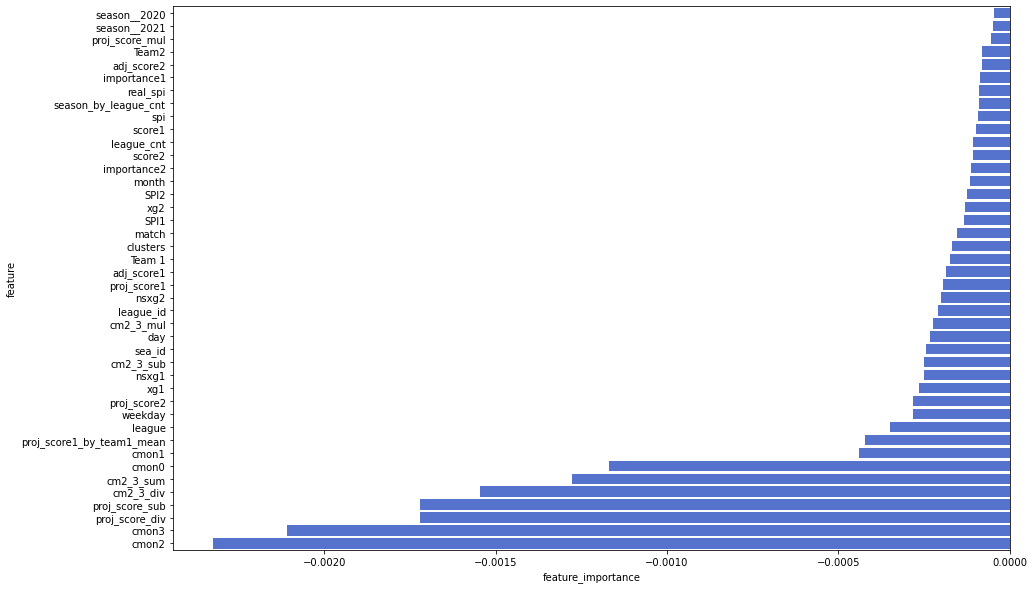

In [76]:
var_imp_plot(perm_imp_rfpimp)

In [ ]:
def objective(trial,data=X,target=y):
    
    train_x, test_x, train_y, test_y = train_test_split(data, target, test_size=0.3,random_state=42, stratify= y)
    
    # To select which parameters to optimize, please look at the XGBoost documentation:
    # https://xgboost.readthedocs.io/en/latest/parameter.html
    param = {
        'random_state': 10,
        'boosting_type': trial.suggest_categorical('boosting_type', ['gbdt', 'goss']),
        #'random_state': trial.suggest_int('random_state', 0,2021),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.5,0.6,0.7,0.8,0.9,1.0]),
        'subsample': trial.suggest_categorical('subsample', [0.6,0.7,0.8,1.0]),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.0001,0.1),
        #'n_estimators': trial.suggest_int("n_estimators", 50, 5000),
        'max_depth': trial.suggest_categorical('max_depth', [4,5,7,9,11,13,15,17,20]),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 300),
        'num_leaves': trial.suggest_int('num_leaves', 15, 120),
    }


    mod = LGBMClassifier(**param, metric= 'binary_logloss', n_estimators=50000)

    mod.fit(train_x, train_y, eval_set=[(test_x, test_y)], early_stopping_rounds=30, verbose = 5000)

    preds = mod.predict_proba(test_x)[:,1]

    roc = log_loss(test_y, preds)
    return roc

In [ ]:
study_lgbm = optuna.create_study(direction="minimize")
study_lgbm.optimize(objective, n_trials=100)
print("Number of finished trials: {}".format(len(study_lgbm.trials)))
print("Best trial:", study_lgbm.best_trial.params)

In [ ]:
study_lgbm.best_params

In [81]:
submission = pd.read_csv('submission.csv')

submission['Outcome'] = pred[:,1]

submission.to_csv('sub5.csv',index=False, header=True)

In [69]:
def objective_cat(trial, data = X, target = y):
    train_x, valid_x, train_y, valid_y = train_test_split(data, target, test_size=0.3)

    param = {
        #'n_estimators': trial.suggest_int("n_estimators", 50, 5000),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.0001, 0.1),
        #"objective": trial.suggest_categorical("objective", ["Logloss", "CrossEntropy"]),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1),
        "depth": trial.suggest_int("depth", 1, 12),
        'l2_leaf_reg': trial.suggest_categorical('l2_leaf_reg',[1,2,3,4,5,6,7,8,9]),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical(
            "bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]
        ),
        "used_ram_limit": "8gb",
    }

    if param["bootstrap_type"] == "Bayesian":
        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif param["bootstrap_type"] == "Bernoulli":
        param["subsample"] = trial.suggest_float("subsample", 0.1, 1)

    gbm = CatBoostClassifier(**param, verbose=0, eval_metric= 'Logloss')

    gbm.fit(train_x, train_y, eval_set=[(valid_x, valid_y)], verbose=500, early_stopping_rounds=30)

    preds = gbm.predict_proba(valid_x)

    roc = log_loss(valid_y, preds[:,1])
    return roc


In [70]:
study_cat = optuna.create_study(direction="minimize")
study_cat.optimize(objective_cat, n_trials=100)
print("Number of finished trials: {}".format(len(study_cat.trials)))
print("Best trial:", study_cat.best_trial.params)

[I 2021-08-26 17:56:50,053] A new study created in memory with name: no-name-b0d0fca2-b0c7-455b-9d95-d32e978bf91a


0:	learn: 0.6925109	test: 0.6925092	best: 0.6925092 (0)	total: 3.94ms	remaining: 3.94s
500:	learn: 0.3438468	test: 0.3425480	best: 0.3425480 (500)	total: 2.39s	remaining: 2.38s


[I 2021-08-26 17:56:55,108] Trial 0 finished with value: 0.1845911129227492 and parameters: {'learning_rate': 0.0009328243706462321, 'colsample_bylevel': 0.025898005517272775, 'depth': 8, 'l2_leaf_reg': 7, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 0 with value: 0.1845911129227492.


999:	learn: 0.1861493	test: 0.1845911	best: 0.1845911 (999)	total: 4.64s	remaining: 0us

bestTest = 0.1845911129
bestIteration = 999

0:	learn: 0.6904205	test: 0.6904180	best: 0.6904180 (0)	total: 13.4ms	remaining: 13.3s
500:	learn: 0.1263189	test: 0.1250562	best: 0.1250562 (500)	total: 6.5s	remaining: 6.47s
999:	learn: 0.0411888	test: 0.0397953	best: 0.0397953 (999)	total: 13.9s	remaining: 0us

bestTest = 0.03979525508
bestIteration = 999



[I 2021-08-26 17:57:09,638] Trial 1 finished with value: 0.039795255076376906 and parameters: {'learning_rate': 0.0009056890753266238, 'colsample_bylevel': 0.09757031026102421, 'depth': 5, 'l2_leaf_reg': 3, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 1 with value: 0.039795255076376906.


0:	learn: 0.6294272	test: 0.6303389	best: 0.6303389 (0)	total: 5.12ms	remaining: 5.11s


[I 2021-08-26 17:57:10,656] Trial 2 finished with value: 0.019958611418471054 and parameters: {'learning_rate': 0.0990265823493364, 'colsample_bylevel': 0.05660927098320313, 'depth': 1, 'l2_leaf_reg': 1, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.1625356723471394}. Best is trial 2 with value: 0.019958611418471054.


Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.01995861142
bestIteration = 73

Shrink model to first 74 iterations.
0:	learn: 0.6770894	test: 0.6772439	best: 0.6772439 (0)	total: 5.35ms	remaining: 5.35s
500:	learn: 0.0149068	test: 0.0183249	best: 0.0183249 (500)	total: 8.53s	remaining: 8.5s
999:	learn: 0.0086354	test: 0.0141900	best: 0.0141900 (999)	total: 15.3s	remaining: 0us

bestTest = 0.01418997568
bestIteration = 999



[I 2021-08-26 17:57:26,679] Trial 3 finished with value: 0.014189975681674918 and parameters: {'learning_rate': 0.006109272995673817, 'colsample_bylevel': 0.05168609734389754, 'depth': 11, 'l2_leaf_reg': 9, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.327417704025345}. Best is trial 3 with value: 0.014189975681674918.


0:	learn: 0.6925324	test: 0.6925541	best: 0.6925541 (0)	total: 4.71ms	remaining: 4.7s
500:	learn: 0.1356218	test: 0.1396624	best: 0.1396624 (500)	total: 2.76s	remaining: 2.75s
999:	learn: 0.0506338	test: 0.0556606	best: 0.0556606 (999)	total: 5.37s	remaining: 0us

bestTest = 0.05566062583
bestIteration = 999



[I 2021-08-26 17:57:32,531] Trial 4 finished with value: 0.05566062582969476 and parameters: {'learning_rate': 0.004381263198841494, 'colsample_bylevel': 0.014136354026034616, 'depth': 7, 'l2_leaf_reg': 2, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 3.323910720327704}. Best is trial 3 with value: 0.014189975681674918.


0:	learn: 0.6931094	test: 0.6931071	best: 0.6931071 (0)	total: 5.05ms	remaining: 5.05s
500:	learn: 0.5095800	test: 0.5101181	best: 0.5101181 (500)	total: 9s	remaining: 8.96s
999:	learn: 0.3752738	test: 0.3764890	best: 0.3764890 (999)	total: 18.9s	remaining: 0us

bestTest = 0.3764890432
bestIteration = 999



[I 2021-08-26 17:57:51,978] Trial 5 finished with value: 0.37648904322251964 and parameters: {'learning_rate': 0.0002791236550337607, 'colsample_bylevel': 0.035866818156883064, 'depth': 11, 'l2_leaf_reg': 6, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.6023232593444211}. Best is trial 3 with value: 0.014189975681674918.


0:	learn: 0.6930718	test: 0.6930733	best: 0.6930733 (0)	total: 4.39ms	remaining: 4.39s
500:	learn: 0.6168895	test: 0.6174938	best: 0.6174938 (500)	total: 3.6s	remaining: 3.59s
999:	learn: 0.5544845	test: 0.5555908	best: 0.5555908 (999)	total: 6.09s	remaining: 0us

bestTest = 0.5555907879
bestIteration = 999



[I 2021-08-26 17:57:58,528] Trial 6 finished with value: 0.5555907878786764 and parameters: {'learning_rate': 0.00010568716725808571, 'colsample_bylevel': 0.035552824744894684, 'depth': 4, 'l2_leaf_reg': 6, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 3 with value: 0.014189975681674918.


0:	learn: 0.6867911	test: 0.6866788	best: 0.6866788 (0)	total: 4.01ms	remaining: 4s
500:	learn: 0.0140690	test: 0.0155646	best: 0.0155579 (496)	total: 2.3s	remaining: 2.29s


[I 2021-08-26 17:58:02,624] Trial 7 finished with value: 0.014009637172313587 and parameters: {'learning_rate': 0.009268121098665202, 'colsample_bylevel': 0.03176477175071959, 'depth': 4, 'l2_leaf_reg': 5, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 7 with value: 0.014009637172313587.


Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.01400963717
bestIteration = 799

Shrink model to first 800 iterations.
0:	learn: 0.6922203	test: 0.6922161	best: 0.6922161 (0)	total: 5.06ms	remaining: 5.05s
500:	learn: 0.3851468	test: 0.3846341	best: 0.3846341 (500)	total: 2.7s	remaining: 2.69s


[I 2021-08-26 17:58:08,265] Trial 8 finished with value: 0.21544939631929041 and parameters: {'learning_rate': 0.00035011586725400425, 'colsample_bylevel': 0.07025309157478811, 'depth': 4, 'l2_leaf_reg': 7, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 4.0990362555974}. Best is trial 7 with value: 0.014009637172313587.


999:	learn: 0.2158519	test: 0.2154494	best: 0.2154494 (999)	total: 5.25s	remaining: 0us

bestTest = 0.2154493963
bestIteration = 999

0:	learn: 0.6726550	test: 0.6727291	best: 0.6727291 (0)	total: 8.9ms	remaining: 8.89s
500:	learn: 0.0123066	test: 0.0176556	best: 0.0176551 (499)	total: 3.87s	remaining: 3.85s


KeyboardInterrupt: 

In [ ]:
study_cat.best_params

In [ ]:
import xgboost as xgb
def objective_xgb(trial, data = X, target = y):
    train_x, valid_x, train_y, valid_y = train_test_split(data, target, test_size=0.25)
    dtrain = xgb.DMatrix(train_x, label=train_y)
    dvalid = xgb.DMatrix(valid_x, label=valid_y)

    param = {
        "verbosity": 0,
        #"objective": "binary:logistic",
        #'n_estimators': trial.suggest_int("n_estimators", 50, 5000),
        "booster": trial.suggest_categorical("booster", ["gbtree", "dart"]),
        "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
        "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True)}

    if param["booster"] == "gbtree" or param["booster"] == "dart":
        param["max_depth"] = trial.suggest_int("max_depth", 1, 9)
        param["eta"] = trial.suggest_float("eta", 1e-8, 1.0, log=True)
        param["gamma"] = trial.suggest_float("gamma", 1e-8, 1.0, log=True)
        param["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])
    if param["booster"] == "dart":
        param["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
        param["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
        param["rate_drop"] = trial.suggest_float("rate_drop", 1e-8, 1.0, log=True)
        param["skip_drop"] = trial.suggest_float("skip_drop", 1e-8, 1.0, log=True)

    gbm = XGBClassifier(**param, eval_metric= 'logloss')

    gbm.fit(train_x, train_y, eval_set=[(valid_x, valid_y)], early_stopping_rounds=100, verbose = 500)

    preds = gbm.predict_proba(valid_x)

    roc = log_loss(valid_y, preds[:,1])
    return roc


In [ ]:
study = optuna.create_study(direction="minimize")
study.optimize(objective_xgb, n_trials=100)
print("Number of finished trials: {}".format(len(study.trials)))
print("Best trial:", study.best_trial.params)

In [ ]:
study.best_params